In [1]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers, losses
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
IMG_SIZE = 160
IMAGE_SHAPE = [160,160]

In [4]:
def load_images_from_folder(folderName):
    image_list =[]
    for fileIndex in range(7000):
      img = cv2.imread(r"C:\Users\Lenovo\Desktop\landscape Images/"+folderName+"/"+str(fileIndex)+".jpg")
      if folderName == "color": 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
      else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
      image_list.append(img)
    return image_list
color = np.empty((0,IMG_SIZE,IMG_SIZE,3))
gray = np.empty((0,IMG_SIZE,IMG_SIZE,1))
color  = np.append(color,load_images_from_folder(r"color"),0)
gray  = np.append(gray,load_images_from_folder(r"gray"),0)

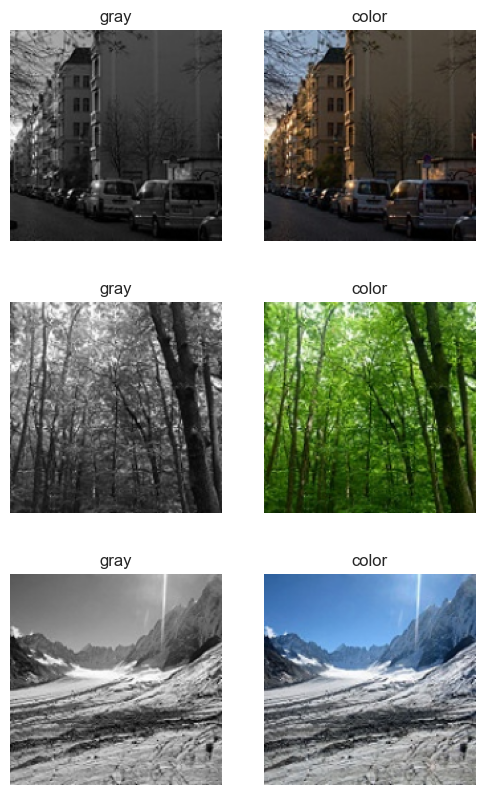

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 10))
for i in range(0,6,2):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(cv2.cvtColor(gray[i].astype('uint8'), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis("off")
  ax = plt.subplot(3, 2, i + 2)
  plt.imshow(color[i].astype('uint8'))
  plt.title("color")
  plt.axis("off")

In [6]:
color.shape,gray.shape

((7000, 160, 160, 3), (7000, 160, 160, 1))

In [7]:
color /= 255
gray /= 255

In [8]:
def Colorizer(input_shape):
  encoder_input = keras.Input(shape=input_shape)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(encoder_input)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1)(x)   
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(256, (5, 5), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    
  encoder_output =  layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(x)

  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)(x)
  decoder_output = layers.UpSampling2D((2, 2))(x)
  return keras.Model(encoder_input, decoder_output, name="decoder")

colorizer = Colorizer((160,160,1))

In [9]:
colorizer.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 256)       1638

In [10]:
def loss(y_true,y_pred) :
    l = tf.sqrt(tf.reduce_mean(tf.square(tf.abs(y_true - y_pred))))
    return l

In [11]:
# earlystopping = keras.callbacks.EarlyStopping(
#     monitor="accuracy",
#     patience=3, 
# )
colorizer.compile(loss=loss, optimizer='adam', metrics=['accuracy','mae','mse'])

In [12]:
# hist = colorizer.fit(gray[:4000], color[:4000],batch_size=32,epochs=100, callbacks = [earlystopping], validation_data = (gray[4001:5000], color[4001:5000]))
hist = colorizer.fit(gray[:6000], color[:6000],batch_size=32,epochs=35,validation_data = (gray[6000:7000], color[6000:7000]))

Epoch 1/35
188/188 [==============================] - 2668s 14s/step - loss: 0.1519 - accuracy: 0.3914 - mae: 0.1146 - mse: 0.0247 - val_loss: 0.1187 - val_accuracy: 0.4455 - val_mae: 0.0847 - val_mse: 0.0141
Epoch 2/35
188/188 [==============================] - 3189s 17s/step - loss: 0.1187 - accuracy: 0.4518 - mae: 0.0852 - mse: 0.0142 - val_loss: 0.1124 - val_accuracy: 0.4239 - val_mae: 0.0796 - val_mse: 0.0127
Epoch 3/35
188/188 [==============================] - 1088s 6s/step - loss: 0.1135 - accuracy: 0.4658 - mae: 0.0808 - mse: 0.0129 - val_loss: 0.1101 - val_accuracy: 0.4849 - val_mae: 0.0775 - val_mse: 0.0122
Epoch 4/35
188/188 [==============================] - 1097s 6s/step - loss: 0.1114 - accuracy: 0.4731 - mae: 0.0791 - mse: 0.0125 - val_loss: 0.1181 - val_accuracy: 0.4848 - val_mae: 0.0866 - val_mse: 0.0140
Epoch 5/35
188/188 [==============================] - 1319s 7s/step - loss: 0.1095 - accuracy: 0.4777 - mae: 0.0776 - mse: 0.0120 - val_loss: 0.1059 - val_accuracy: 0

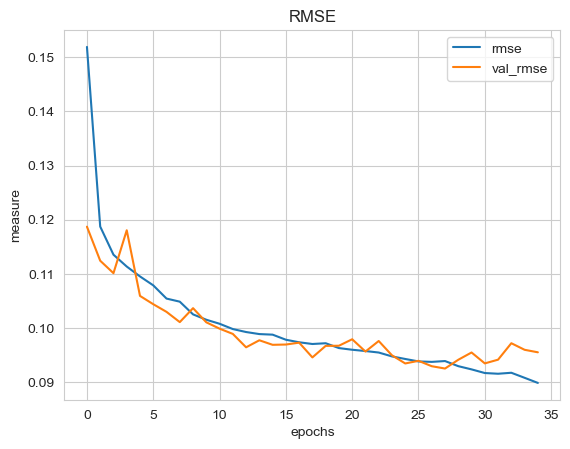

In [13]:
ax = plt.subplot(label= True)
plt.plot(hist.history["loss"], label = "rmse")
plt.plot(hist.history["val_loss"], label = "val_rmse")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('RMSE')
plt.legend(["rmse", "val_rmse"])

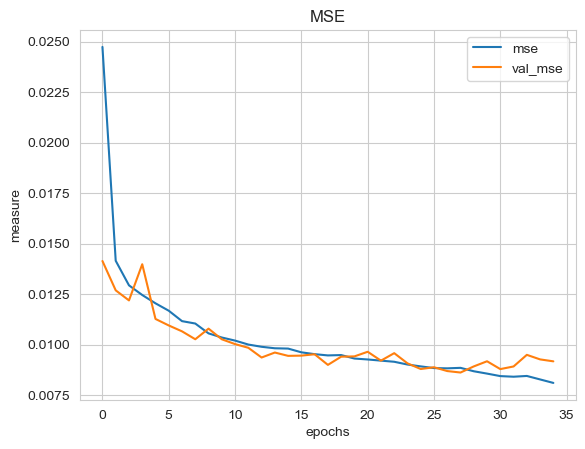

In [14]:
ax = plt.subplot(label= True)
plt.plot(hist.history["mse"], label = "mse")
plt.plot(hist.history["val_mse"], label = "val_mse")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('MSE')
plt.legend(["mse", "val_mse"])

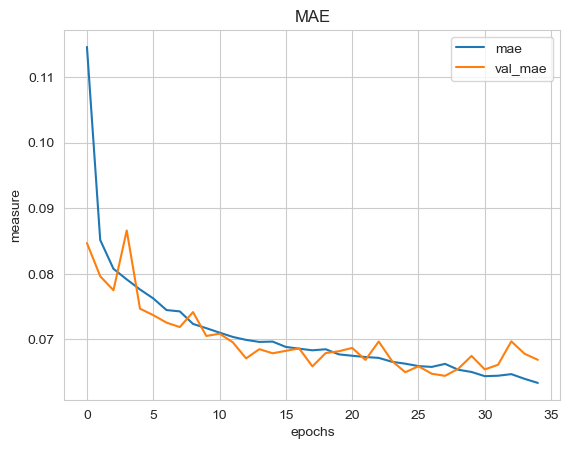

In [15]:
ax = plt.subplot(label= True)
plt.plot(hist.history["mae"], label = "mae")
plt.plot(hist.history["val_mae"], label = "val_mae")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('MAE')
plt.legend(["mae", "val_mae"])

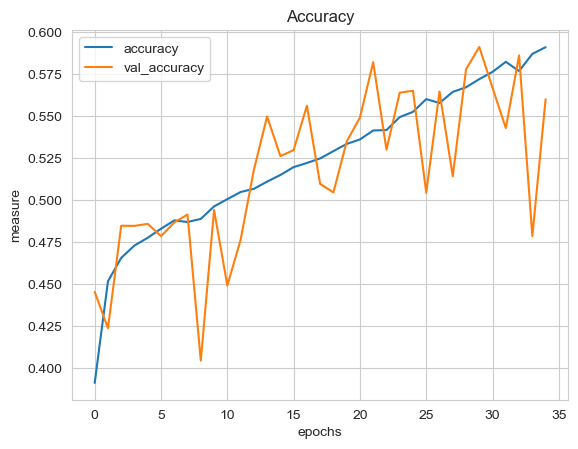

In [16]:
ax = plt.subplot(label= True)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
plt.ylabel('measure')
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(["accuracy", "val_accuracy"])

In [17]:
colorized_deneme = colorizer.predict(gray[0:1000])

32/32 [==============================] - 155s 5s/step


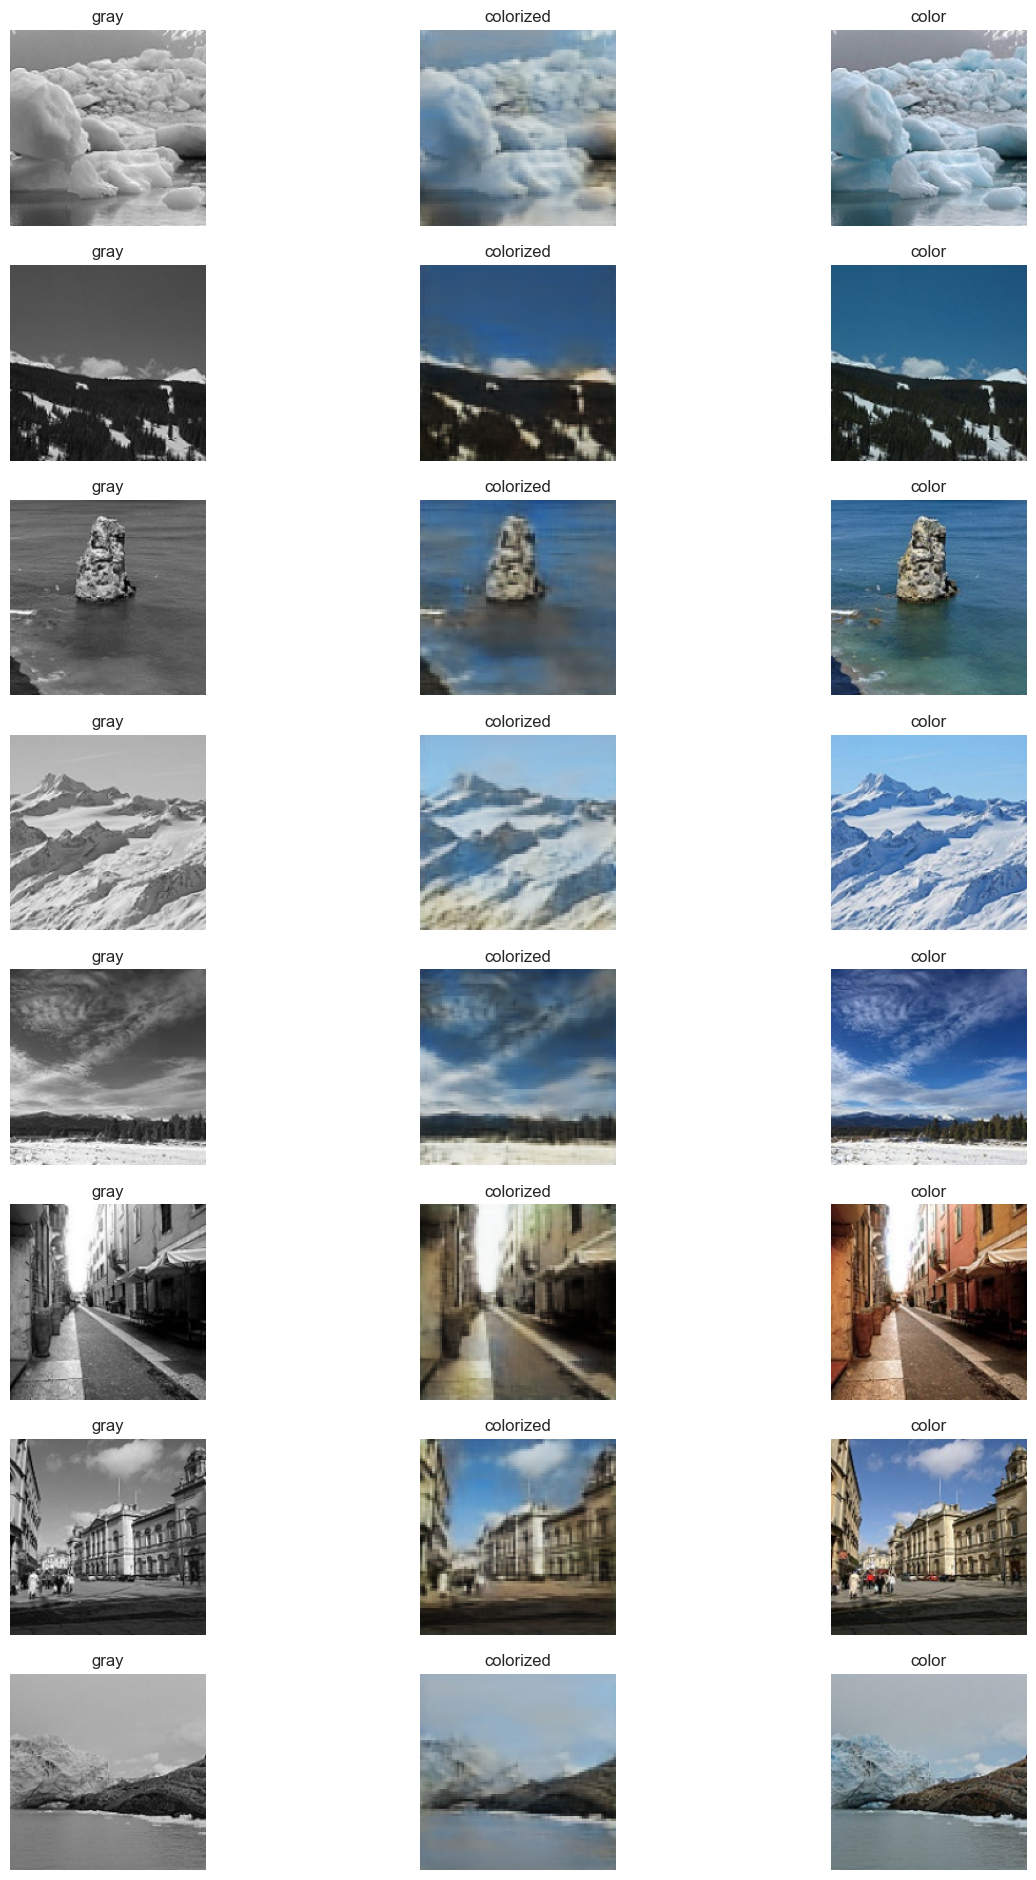

In [18]:
plt.figure(figsize=(15,30))
for i in range(6,30,3):
  ax = plt.subplot(10, 3, i + 1)
  plt.imshow(cv2.cvtColor(gray[0+i].astype("float32"), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 2)
  plt.imshow(colorized_deneme[i])
  plt.title("colorized")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 3)
  plt.imshow(color[0+i])
  plt.title("color")
  plt.axis('off')

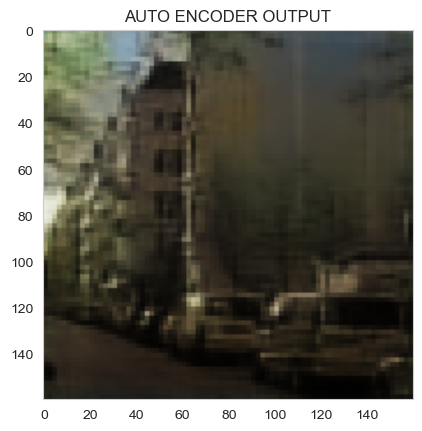

In [19]:

# plt.figure(figsize=(5,5))
plt.imshow(colorized_deneme[0])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

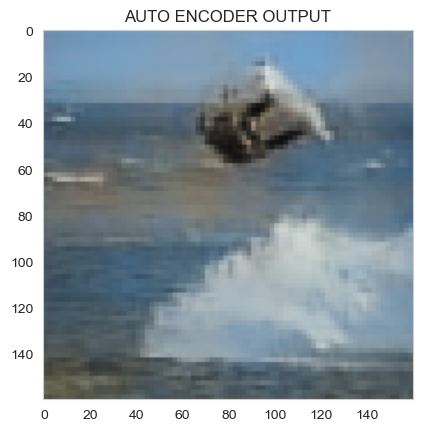

In [20]:
plt.imshow(colorized_deneme[64])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

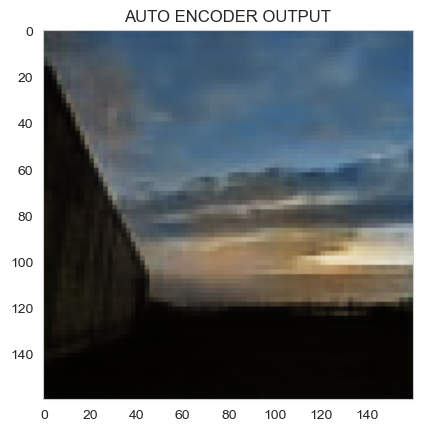

In [21]:
plt.imshow(colorized_deneme[320])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

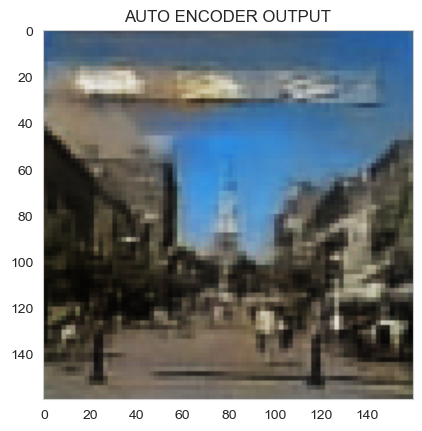

In [24]:
plt.imshow(colorized_deneme[450])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

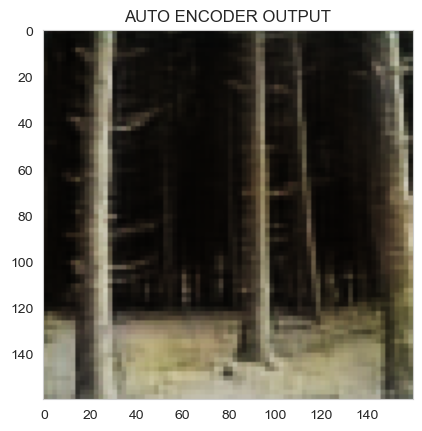

In [23]:
plt.imshow(colorized_deneme[680])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)